## Loading Libraries and Train Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from langdetect import detect
import os

In [2]:
corpora_df = pd.read_excel('Project Corpora/train.xlsx')

In [3]:
corpora_df.tail()

,index,description,host_about,unlisted
12491,12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1
12495,12496,This brandnew Apartment combines elegant charm...,We are a German-Portuguese couple with a Passi...,1


In [4]:
corpora_df.description.isna().sum()

0

In [5]:
corpora_df.shape

(12496, 4)

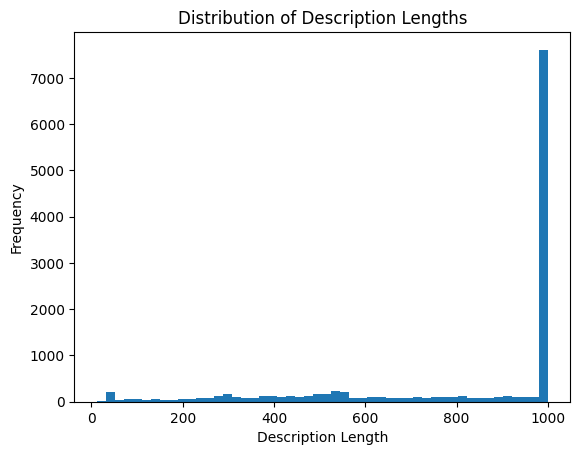

In [6]:
description_lengths = corpora_df['description'].str.len()

# Plot the distribution of description lengths
plt.hist(description_lengths, bins=50)
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.title('Distribution of Description Lengths')
plt.show()

## Detecting Languages (description, host_about) 

In [7]:
# Define a function to detect the language of a string
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = None
    return lang

In [8]:
train_df = pd.read_excel('Project Corpora/train.xlsx')
train_df.to_csv('output/train.csv', index=False)

In [9]:
# Detecting languages  >>>>>>>>>>>>>>>>>> RUN THIS ONLY ONCE: IT APPENDS IN THE END OF FILE
source_file = 'output/train.csv'
destination_file = 'output/train_with_language.csv'

chunk_size = 500
chunk_iterator = pd.read_csv(source_file, chunksize=chunk_size)

# Processing data in chunks
for chunk in tqdm(chunk_iterator):
    chunk['description'] = chunk['description'].str.replace('<br/>', '')
    chunk['description'] = chunk['description'].str.replace('_x000D_', '')
    chunk['description_language'] = chunk['description'].apply(detect_language)
    
    chunk['host_about'] = chunk['host_about'].str.replace('<br/>', '')
    chunk['host_about'] = chunk['host_about'].str.replace('_x000D_', '')
    chunk['host_about_language'] = chunk['host_about'].apply(detect_language)
    
    chunk.to_csv(destination_file, 
                 index=False, 
                 mode='a', 
                 header=not os.path.exists(destination_file))

25it [01:03,  2.56s/it]


In [10]:
train_df = pd.read_csv('output/train_with_language.csv')
train_df.head()

,index,description,host_about,unlisted,description_language,host_about_language
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!\nI m Portuguese and i love to meet peop...,0,pt,en
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr


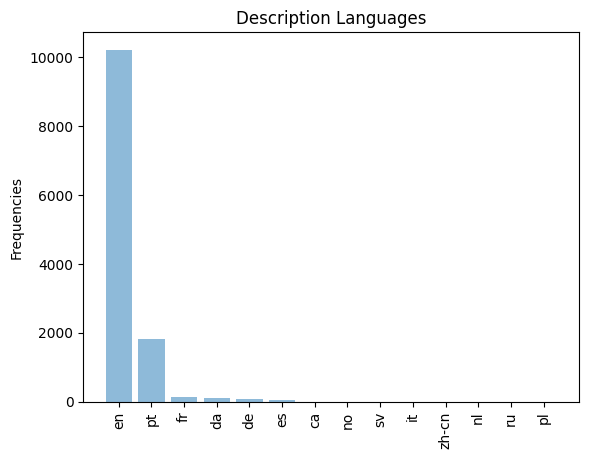

In [11]:
freq = pd.Series(train_df['description_language']).value_counts()

x_labels = freq.index[0:20]
values = freq[:20]
plt.bar(x_labels, values, align='center', alpha=0.5)
#plt.xticks(values, x_labels)
plt.ylabel('Frequencies')
plt.title('Description Languages')
plt.xticks(rotation=90)
plt.show()

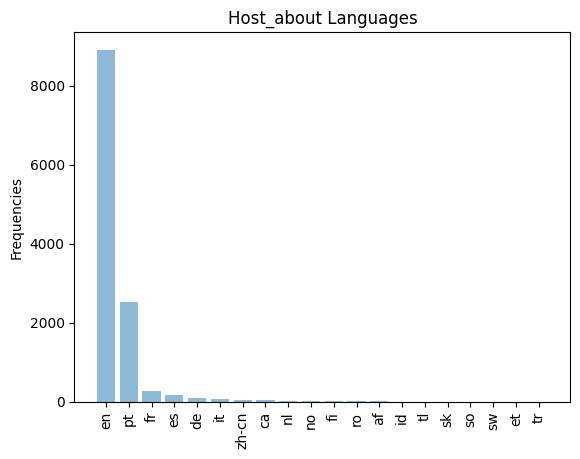

In [12]:
freq = pd.Series(train_df['host_about_language']).value_counts()

x_labels = freq.index[0:20]
values = freq[:20]
plt.bar(x_labels, values, align='center', alpha=0.5)
#plt.xticks(values, x_labels)
plt.ylabel('Frequencies')
plt.title('Host_about Languages')
plt.xticks(rotation=90)
plt.show()

In [13]:
description_languages = set(train_df['description_language'])
print("description_languages:", description_languages)
print("total number:", len(description_languages))
print("-----------------")
host_about_languages = set(train_df['host_about_language'])
print("host_about_languages:", host_about_languages)
print("total number:", len(host_about_languages))

description_languages: {'ca', 'sv', 'de', 'en', 'da', 'zh-cn', 'nl', 'fr', 'ru', 'pl', 'es', 'it', 'no', 'pt'}
total number: 14
-----------------
host_about_languages: {'sv', 'hr', 'zh-cn', 'fr', 'no', 'sk', 'vi', 'zh-tw', 'hu', 'en', 'nl', 'cs', 'ko', 'lt', 'tl', 'ca', 'tr', 'he', 'da', 'sw', 'ru', 'es', 'ro', 'it', 'id', 'pt', 'sl', 'de', 'fi', 'et', 'af', nan, 'so'}
total number: 33


## Translating Descriptions

The following transformer model will be used to translate non-English text into English:

https://huggingface.co/Helsinki-NLP/opus-mt-mul-en

Source group: 120 languages 
Target group: English

In [14]:
from transformers import MarianMTModel, MarianTokenizer

def translate_text_multilingual(text):
    model_name = "Helsinki-NLP/opus-mt-mul-en"  # Multilingual to English translation model
    model = MarianMTModel.from_pretrained(model_name)
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    
    # Tokenize the input text
    input_ids = tokenizer.encode(text, return_tensors="pt")
    
    # Perform translation
    translated_ids = model.generate(input_ids)
    
    # Decode the translated output
    translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
    
    return translated_text

In [15]:
# Test
text = "Olá. Nosso apartamento é simplesmente incrível."
translated_text = translate_text_multilingual(text)
print(translated_text)

/Users/iryna/Documents/projects/NovaIMS/TM/.tm_env/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/Users/iryna/Documents/projects/NovaIMS/TM/.tm_env/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Hey, our apartment's just amazing.


### Ttranslating of descriptions -- TIME CONSUMING STEP

In [19]:
# Translating 'description' column, creating a new column 'description_english', and storing dataset for the future

descriptions = train_df.description
description_languages = train_df.description_language

description_english = []

for i in tqdm(range(len(descriptions))):
    if description_languages[i] == 'en':
        description_english.append(descriptions[i])
    else:
        source = descriptions[i].replace('<br/>', '')
        source = source.replace('_x000D_', '')
        translated = translate_text_multilingual(source)
        description_english.append(translated)
        
# Add a new column to train_df
train_df['description_english'] = description_english
train_df.to_csv('output/train_with_translation.csv', index=False)

train_df.tail(5)

  0%|                                                 | 0/12496 [00:00<?, ?it/s]/Users/iryna/Documents/projects/NovaIMS/TM/.tm_env/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/Users/iryna/Documents/projects/NovaIMS/TM/.tm_env/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|███████████████████████████████████| 12496/12496 [4:54:18<00:00,  1.41s/it]


,index,description,host_about,unlisted,description_language,host_about_language,description_english
12491,12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0,en,en,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0,en,en,Beautifully located in the heart of Lisbon's h...
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0,en,en,Enjoy breakfast in the sleek kitchen with its ...
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1,pt,pt,The Earth of Eira is a farm surrounded by frui...
12495,12496,This brandnew Apartment combines elegant charm...,We are a German-Portuguese couple with a Passi...,1,en,en,This brandnew Apartment combines elegant charm...
